# Calculating band indices <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
For example, one of the most commonly used indices is the Normalised Difference Vegetation Index (NDVI), which uses the ratio of the red and near-infrared (NIR) band to highlight healthy vegetation (see [here](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php) for a deeper explanation). Using Digital Earth Africa's archive of analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms.


## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculate_indices` from `deafrica_bandindices.py`
 
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Calculating_band_indices')

## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. 
We will use data from the Landsat 8 satellite:

In [3]:
lat, lon = 13.94, -16.54
buffer = 0.125

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2016-06', '2017-06'),
    'resolution': (-30, 30)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, 
              products=['ls8_usgs_sr_scene'],
              min_gooddata=0.99, 
              output_crs=output_crs,
              align=(15, 15),
              **query)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Counting good quality pixels for each time step
Filtering to 4 out of 72 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


In [4]:
ds

<xarray.Dataset>
Dimensions:          (time: 4, x: 907, y: 929)
Coordinates:
  * time             (time) datetime64[ns] 2016-06-19T11:27:11.943752 ... 201...
  * y                (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x                (x) float64 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref      int32 32628
Data variables:
    coastal_aerosol  (time, y, x) float32 724.0 733.0 796.0 ... 916.0 927.0
    blue             (time, y, x) float32 870.0 884.0 979.0 ... 1187.0 1184.0
    green            (time, y, x) float32 1584.0 1574.0 1675.0 ... 1799.0 1768.0
    red              (time, y, x) float32 2230.0 2182.0 2339.0 ... 2338.0 2312.0
    nir              (time, y, x) float32 3462.0 3476.0 3567.0 ... 3526.0 3506.0
    swir1            (time, y, x) float32 4851.0 4688.0 4723.0 ... 5430.0 5439.0
    swir2            (time, y, x) float32 3822.0 3682.0 3869.0 ... 5182.0 5179.0
    sr_aerosol       (time, y, x) float32 96.0 96.0 96.0 ... 160.0 130.0 160.0
    radsat_qa        (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 ... 322 322 322 322
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the timesteps in our dataset as true colour RGB images:

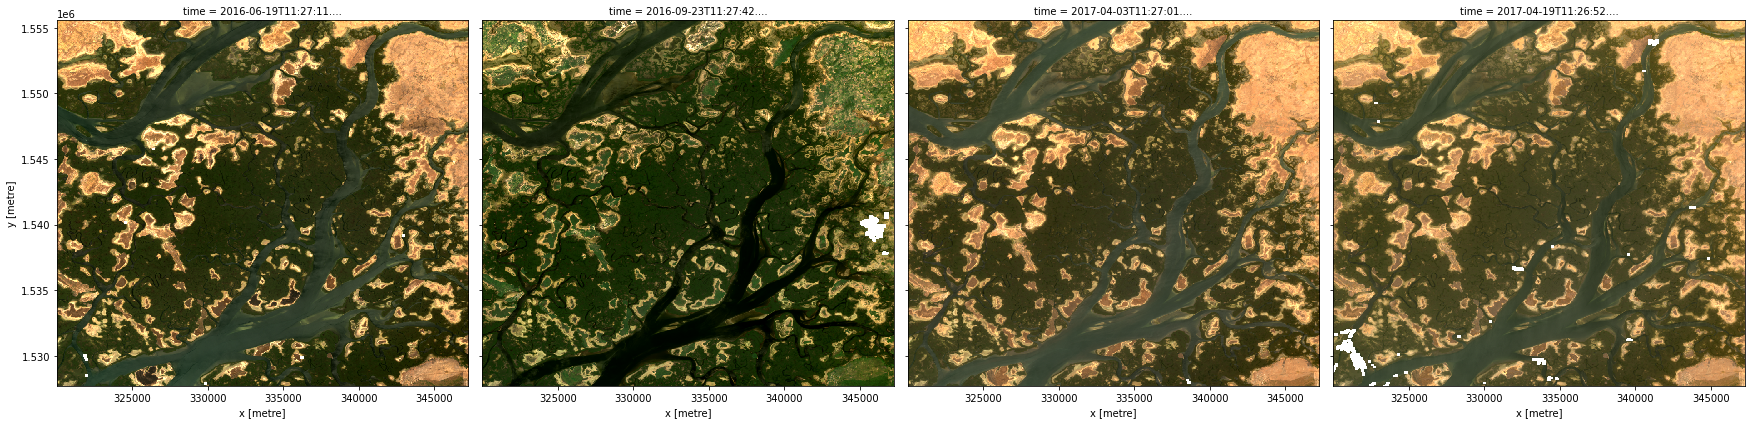

In [5]:
# Plot as an RGB image
rgb(ds, col='time')


## Manually calculate an index
One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. 
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation.
The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.


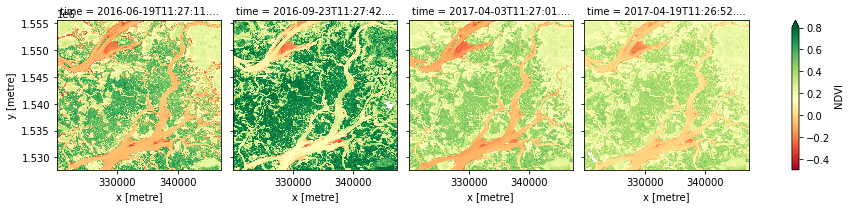

In [6]:
# Calculate NDVI using the formula above
ds['NDVI'] = (ds.nir - ds.red) / (ds.nir + ds.red)

# Plot the results for one time step to see what they look like:
ds.NDVI.plot(col='time', vmin=-0.50, vmax=0.8, cmap='RdYlGn')


In the image above, vegetation shows up as green (NDVI > 0). 
Sand shows up as yellow (NDVI ~ 0) and water shows up as red (NDVI < 0).

## Use the `calculate_indices` function to calculate an index

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- **AWEI_ns** (Automated Water Extraction Index,no shadows, Feyisa 2014)
- **AWEI_sh** (Automated Water Extraction Index,shadows, Feyisa 2014)
- **BAEI**    (Built-Up Area Extraction Index, Bouzekri et al. 2015) 
- **BAI**     (Burn Area Index, Martin 1998)
- **BSI**     (Bare Soil Index, Rikimaru et al. 2002)
- **BUI**     (Built-Up Index, He et al. 2010)
- **CMR**     (Clay Minerals Ratio, Drury 1987)
- **EVI**     (Enhanced Vegetation Index, Huete 2002)
- **FMR**     (Ferrous Minerals Ratio, Segal 1982)
- **IOR**     (Iron Oxide Ratio, Segal 1982)  
- **LAI**     (Leaf Area Index, Boegh 2002)
- **MNDWI**   (Modified Normalised Difference Water Index, Xu 1996) 
- **MSAVI**   (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)              
- **NBI**     (New Built-Up Index, Jieli et al. 2010)
- **NBR**     (Normalised Burn Ratio, Lopez Garcia 1991)
- **NDBI**    (Normalised Difference Built-Up Index, Zha 2003)
- **NDCI**    (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)
- **NDMI**    (Normalised Difference Moisture Index, Gao 1996)        
- **NDSI**    (Normalised Difference Snow Index, Hall 1995)
- **NDVI**    (Normalised Difference Vegetation Index, Rouse 1973)
- **NDWI**    (Normalised Difference Water Index, McFeeters 1996)
- **SAVI**    (Soil Adjusted Vegetation Index, Huete 1988)
- **TCB**     (Tasseled Cap Brightness, Crist 1985)
- **TCG**     (Tasseled Cap Greeness, Crist 1985)
- **TCW**     (Tasseled Cap Wetness, Crist 1985)
- **WI**      (Water Index, Fisher 2016) 


The `calculate_indices` function can be found in the [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py) script. This script provides all required band math involved in creating each index and is worth a look.


### Using `calculate_indices` to get the same result
The function provides a simple way to calculate band indices without needing to explicitly write code for the band math.

In [7]:
calculate_indices(ds, index=['NDVI'], collection='c1')

<xarray.Dataset>
Dimensions:          (time: 4, x: 907, y: 929)
Coordinates:
  * time             (time) datetime64[ns] 2016-06-19T11:27:11.943752 ... 201...
  * y                (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x                (x) float64 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref      int32 32628
Data variables:
    coastal_aerosol  (time, y, x) float32 724.0 733.0 796.0 ... 916.0 927.0
    blue             (time, y, x) float32 870.0 884.0 979.0 ... 1187.0 1184.0
    green            (time, y, x) float32 1584.0 1574.0 1675.0 ... 1799.0 1768.0
    red              (time, y, x) float32 2230.0 2182.0 2339.0 ... 2338.0 2312.0
    nir              (time, y, x) float32 3462.0 3476.0 3567.0 ... 3526.0 3506.0
    swir1            (time, y, x) float32 4851.0 4688.0 4723.0 ... 5430.0 5439.0
    swir2            (time, y, x) float32 3822.0 3682.0 3869.0 ... 5182.0 5179.0
    sr_aerosol       (time, y, x) float32 96.0 96.0 96.0 ... 160.0 130.0 160.0
    radsat_qa        (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 ... 322 322 322 322
    NDVI             (time, y, x) float32 0.21644412 0.22870274 ... 0.20522518
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

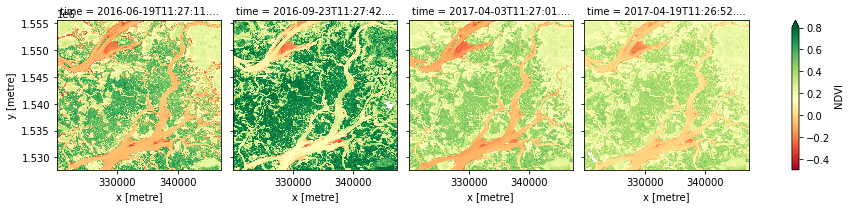

In [8]:
# Calculate NDVI using `calculate indices`
ds_ndvi = calculate_indices(ds, index='NDVI', collection='c1')

# Plot the results 
ds_ndvi.NDVI.plot(col='time', vmin=-0.50, vmax=0.8, cmap='RdYlGn')


> **Note**: when using the `calculate_indices` function, it is important to set the `collection` parameter correctly. 
This is because different satellite collections use different names for the same bands, which can lead to invalid results if not accounted for. 
For Landsat Collection 1, specify `collection='c1'`. 
For Landsat Collection 2, specify `collection='c2'`. 
For Sentinel-2 , specify `collection='s2'`.

### Using `calculate_indices` to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Modified Normalised Difference Index (`MNDWI`).
The new indices will appear in the list of `data_variables` below:

In [9]:
# Calculate multiple indices
ds_multi = calculate_indices(ds, index=['NDVI', 'NDWI', 'MNDWI'], collection='c1')
print(ds_multi)


<xarray.Dataset>
Dimensions:          (time: 4, x: 907, y: 929)
Coordinates:
  * time             (time) datetime64[ns] 2016-06-19T11:27:11.943752 ... 201...
  * y                (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x                (x) float64 3.2e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref      int32 32628
Data variables:
    coastal_aerosol  (time, y, x) float32 724.0 733.0 796.0 ... 916.0 927.0
    blue             (time, y, x) float32 870.0 884.0 979.0 ... 1187.0 1184.0
    green            (time, y, x) float32 1584.0 1574.0 1675.0 ... 1799.0 1768.0
    red              (time, y, x) float32 2230.0 2182.0 2339.0 ... 2338.0 2312.0
    nir              (time, y, x) float32 3462.0 3476.0 3567.0 ... 3526.0 3506.0
    swir1            (time, y, x) float32 4851.0 4688.0 4723.0 ... 5430.0 5439.0
    swir2            (time, y, x) float32 3822.0 3682.0 3869.0 ... 5182.0 5179.0
    sr_aerosol       (time, y, x) float32 96.0 96.0 96.0 ... 160.0 130.0 160.0
   

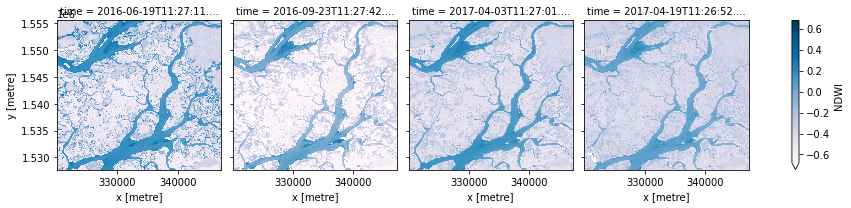

In [10]:
# Plot the NDWI results 
ds_multi.NDWI.plot(col='time', robust=True, cmap='PuBu')

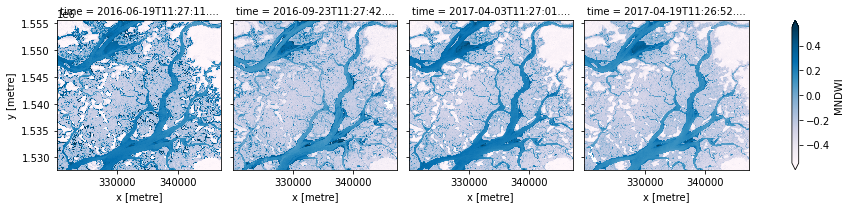

In [11]:
# Plot the MNDWI results 
ds_multi.MNDWI.plot(col='time', robust=True, cmap='PuBu')

We can also drop the original satellite bands from the dataset using `drop=True`. 
The dataset produced below should now only include the new `'NDVI', 'NDWI', 'MNDWI'` bands under `data_variables`:

In [12]:
# Calculate multiple indices and drop original bands
ds_drop = calculate_indices(ds, index=['NDVI', 'NDWI', 'MNDWI'], drop=True, collection='c1')
print(ds_drop)


Dropping bands ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'sr_aerosol', 'radsat_qa', 'pixel_qa', 'NDVI']
<xarray.Dataset>
Dimensions:      (time: 4, x: 907, y: 929)
Coordinates:
  * time         (time) datetime64[ns] 2016-06-19T11:27:11.943752 ... 2017-04...
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.201e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    NDWI         (time, y, x) float32 -0.37217596 -0.3766337 ... -0.32954115
    MNDWI        (time, y, x) float32 -0.50769234 -0.4972852 ... -0.50936586
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** February 2021

**Last tested:**

In [13]:
from datetime import date
print(date.today())

2021-02-23


**Compatible datacube version:**

In [14]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)